In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import matplotlib as mpl
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pickle
import matplotlib.ticker as mtick
import math
from itertools import combinations
import random
from sklearn.linear_model import LinearRegression
from qgrid import show_grid
from adjustText import adjust_text

In [10]:
plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 4
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams['figure.figsize'] = (3, 2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.linewidth'] = 0.25

In [141]:
sns.set(style="ticks", context="paper", font_scale=1, font="Arial")
sns.set_context("paper",
                rc={
                    "axes.linewidth": 0.25,
                    'xtick.major.size': 2,
                    'xtick.major.width': 0.25,
                    'ytick.major.size': 2,
                    'ytick.major.width': 0.25,
                    'xtick.labelsize': 6,
                    'ytick.labelsize': 6,
                    'axes.labelsize': 7
                })

In [12]:
metrics = ['r2', 'corr', 'mae']
model_palette = {
    'DeepPathNet': '#4c72b0',
    'random forest': '#dd8452',
    'elastic net': '#55a868',
    'PCA': '#c44e52',
    'moCluster': '#8172b3',
    'mixOmics': '#937860'
}

# load data

## load

In [30]:
dl_mutation_sanger_gdsc = pd.read_csv(
    f"../../work_dirs/sanger_gdsc_intersection_noprot/DeepMultiOmicNet/mutation/scores_202107061708_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_sanger_gdsc.groupby(['drug_id',
                                     'run']).max()['corr'].reset_index(),
    dl_mutation_sanger_gdsc.groupby(['drug_id',
                                     'run']).max()['r2'].reset_index(),
    dl_mutation_sanger_gdsc.groupby(['drug_id',
                                     'run']).min()['mae'].reset_index(),
    dl_mutation_sanger_gdsc.groupby(['drug_id',
                                     'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_sanger_gdsc = pd.concat(dl_list, axis=1)
dl_merged_mutation_sanger_gdsc = dl_merged_mutation_sanger_gdsc.loc[:,
                                                                    ~dl_merged_mutation_sanger_gdsc
                                                                    .columns.
                                                                    duplicated(
                                                                    )]
dl_merged_mutation_sanger_gdsc['data'] = 'Sanger+GDSC'

dl_mutation_sanger_ctd2 = pd.read_csv(
    f"../../work_dirs/sanger_ctd2/DeepMultiOmicNet/mutation/scores_202107172358_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_sanger_ctd2.groupby(['drug_id',
                                     'run']).max()['corr'].reset_index(),
    dl_mutation_sanger_ctd2.groupby(['drug_id',
                                     'run']).max()['r2'].reset_index(),
    dl_mutation_sanger_ctd2.groupby(['drug_id',
                                     'run']).min()['mae'].reset_index(),
    dl_mutation_sanger_ctd2.groupby(['drug_id',
                                     'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_sanger_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_mutation_sanger_ctd2 = dl_merged_mutation_sanger_ctd2.loc[:,
                                                                    ~dl_merged_mutation_sanger_ctd2
                                                                    .columns.
                                                                    duplicated(
                                                                    )]
dl_merged_mutation_sanger_ctd2['data'] = 'Sanger+CTD2'

dl_mutation_ccle_gdsc = pd.read_csv(
    f"../../work_dirs/ccle_gdsc_intersection3//DeepMultiOmicNet/mutation/scores_202107260401_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_ccle_gdsc.groupby(['drug_id',
                                   'run']).max()['corr'].reset_index(),
    dl_mutation_ccle_gdsc.groupby(['drug_id',
                                   'run']).max()['r2'].reset_index(),
    dl_mutation_ccle_gdsc.groupby(['drug_id',
                                   'run']).min()['mae'].reset_index(),
    dl_mutation_ccle_gdsc.groupby(['drug_id',
                                   'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_ccle_gdsc = pd.concat(dl_list, axis=1)
dl_merged_mutation_ccle_gdsc = dl_merged_mutation_ccle_gdsc.loc[:,
                                                                ~dl_merged_mutation_ccle_gdsc
                                                                .columns.
                                                                duplicated()]
dl_merged_mutation_ccle_gdsc['data'] = 'CCLE+GDSC'

dl_mutation_ccle_ctd2 = pd.read_csv(
    f"../../work_dirs/ccle_ctd2/DeepMultiOmicNet/mutation/scores_202107291200_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_ccle_ctd2.groupby(['drug_id',
                                   'run']).max()['corr'].reset_index(),
    dl_mutation_ccle_ctd2.groupby(['drug_id',
                                   'run']).max()['r2'].reset_index(),
    dl_mutation_ccle_ctd2.groupby(['drug_id',
                                   'run']).min()['mae'].reset_index(),
    dl_mutation_ccle_ctd2.groupby(['drug_id',
                                   'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_ccle_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_mutation_ccle_ctd2 = dl_merged_mutation_ccle_ctd2.loc[:,
                                                                ~dl_merged_mutation_ccle_ctd2
                                                                .columns.
                                                                duplicated()]

dl_merged_mutation_ccle_ctd2['data'] = 'CCLE+CTD2'

dl_mutation_df = pd.concat([
    dl_merged_mutation_sanger_gdsc, dl_merged_mutation_sanger_ctd2,
    dl_merged_mutation_ccle_gdsc, dl_merged_mutation_ccle_ctd2
])
dl_mutation_df['omics'] = 'Mutation'

In [31]:
dl_cnv_sanger_gdsc = pd.read_csv(
    f"../../work_dirs/sanger_gdsc_intersection_noprot/DeepMultiOmicNet/cnv/scores_202107061709_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_cnv_sanger_gdsc.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_cnv_sanger_gdsc.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_cnv_sanger_gdsc.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_cnv_sanger_gdsc.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_cnv_sanger_gdsc = pd.concat(dl_list, axis=1)
dl_merged_cnv_sanger_gdsc = dl_merged_cnv_sanger_gdsc.loc[:,
                                                          ~dl_merged_cnv_sanger_gdsc
                                                          .columns.duplicated(
                                                          )]
dl_merged_cnv_sanger_gdsc['data'] = 'Sanger+GDSC'

dl_cnv_sanger_ctd2 = pd.read_csv(
    f"../../work_dirs/sanger_ctd2/DeepMultiOmicNet/cnv/scores_202107172359_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_cnv_sanger_ctd2.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_cnv_sanger_ctd2.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_cnv_sanger_ctd2.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_cnv_sanger_ctd2.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_cnv_sanger_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_cnv_sanger_ctd2 = dl_merged_cnv_sanger_ctd2.loc[:,
                                                          ~dl_merged_cnv_sanger_ctd2
                                                          .columns.duplicated(
                                                          )]
dl_merged_cnv_sanger_ctd2['data'] = 'Sanger+CTD2'

dl_cnv_ccle_gdsc = pd.read_csv(
    f"../../work_dirs/ccle_gdsc_intersection3//DeepMultiOmicNet/cnv/scores_202107260401_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_cnv_ccle_gdsc.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_cnv_ccle_gdsc.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_cnv_ccle_gdsc.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_cnv_ccle_gdsc.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_cnv_ccle_gdsc = pd.concat(dl_list, axis=1)
dl_merged_cnv_ccle_gdsc = dl_merged_cnv_ccle_gdsc.loc[:,
                                                      ~dl_merged_cnv_ccle_gdsc.
                                                      columns.duplicated()]
dl_merged_cnv_ccle_gdsc['data'] = 'CCLE+GDSC'

dl_cnv_ccle_ctd2 = pd.read_csv(
    f"../../work_dirs/ccle_ctd2/DeepMultiOmicNet/cnv/scores_202107300305_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_cnv_ccle_ctd2.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_cnv_ccle_ctd2.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_cnv_ccle_ctd2.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_cnv_ccle_ctd2.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_cnv_ccle_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_cnv_ccle_ctd2 = dl_merged_cnv_ccle_ctd2.loc[:,
                                                      ~dl_merged_cnv_ccle_ctd2.
                                                      columns.duplicated()]

dl_merged_cnv_ccle_ctd2['data'] = 'CCLE+CTD2'

dl_cnv_df = pd.concat([
    dl_merged_cnv_sanger_gdsc, dl_merged_cnv_sanger_ctd2,
    dl_merged_cnv_ccle_gdsc, dl_merged_cnv_ccle_ctd2
])
dl_cnv_df['omics'] = 'CNV'

In [32]:
dl_rna_sanger_gdsc = pd.read_csv(
    f"../../work_dirs/sanger_gdsc_intersection_noprot/DeepMultiOmicNet/rna/scores_202107061710_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_rna_sanger_gdsc.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_rna_sanger_gdsc.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_rna_sanger_gdsc.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_rna_sanger_gdsc.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_rna_sanger_gdsc = pd.concat(dl_list, axis=1)
dl_merged_rna_sanger_gdsc = dl_merged_rna_sanger_gdsc.loc[:,
                                                          ~dl_merged_rna_sanger_gdsc
                                                          .columns.duplicated(
                                                          )]
dl_merged_rna_sanger_gdsc['data'] = 'Sanger+GDSC'

dl_rna_sanger_ctd2 = pd.read_csv(
    f"../../work_dirs/sanger_ctd2/DeepMultiOmicNet/rna/scores_202107172359_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_rna_sanger_ctd2.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_rna_sanger_ctd2.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_rna_sanger_ctd2.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_rna_sanger_ctd2.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_rna_sanger_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_rna_sanger_ctd2 = dl_merged_rna_sanger_ctd2.loc[:,
                                                          ~dl_merged_rna_sanger_ctd2
                                                          .columns.duplicated(
                                                          )]
dl_merged_rna_sanger_ctd2['data'] = 'Sanger+CTD2'

dl_rna_ccle_gdsc = pd.read_csv(
    f"../../work_dirs/ccle_gdsc_intersection3//DeepMultiOmicNet/rna/scores_202107260401_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_rna_ccle_gdsc.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_rna_ccle_gdsc.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_rna_ccle_gdsc.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_rna_ccle_gdsc.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_rna_ccle_gdsc = pd.concat(dl_list, axis=1)
dl_merged_rna_ccle_gdsc = dl_merged_rna_ccle_gdsc.loc[:,
                                                      ~dl_merged_rna_ccle_gdsc.
                                                      columns.duplicated()]
dl_merged_rna_ccle_gdsc['data'] = 'CCLE+GDSC'

dl_rna_ccle_ctd2 = pd.read_csv(
    f"../../work_dirs/ccle_ctd2/DeepMultiOmicNet/rna/scores_202107300306_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_rna_ccle_ctd2.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_rna_ccle_ctd2.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_rna_ccle_ctd2.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_rna_ccle_ctd2.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_rna_ccle_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_rna_ccle_ctd2 = dl_merged_rna_ccle_ctd2.loc[:,
                                                      ~dl_merged_rna_ccle_ctd2.
                                                      columns.duplicated()]

dl_merged_rna_ccle_ctd2['data'] = 'CCLE+CTD2'

dl_rna_df = pd.concat([
    dl_merged_rna_sanger_gdsc, dl_merged_rna_sanger_ctd2,
    dl_merged_rna_ccle_gdsc, dl_merged_rna_ccle_ctd2
])
dl_rna_df['omics'] = 'RNA'

In [33]:
dl_mutation_cnv_sanger_gdsc = pd.read_csv(
    f"../../work_dirs/sanger_gdsc_intersection_noprot/DeepMultiOmicNet/mutation_cnv/scores_202107071113_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_cnv_sanger_gdsc.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_mutation_cnv_sanger_gdsc.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_mutation_cnv_sanger_gdsc.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_mutation_cnv_sanger_gdsc.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_cnv_sanger_gdsc = pd.concat(dl_list, axis=1)
dl_merged_mutation_cnv_sanger_gdsc = dl_merged_mutation_cnv_sanger_gdsc.loc[:,
                                                          ~dl_merged_mutation_cnv_sanger_gdsc
                                                          .columns.duplicated(
                                                          )]
dl_merged_mutation_cnv_sanger_gdsc['data'] = 'Sanger+GDSC'

dl_mutation_cnv_sanger_ctd2 = pd.read_csv(
    f"../../work_dirs/sanger_ctd2/DeepMultiOmicNet/mutation_cnv/scores_202107191218_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_cnv_sanger_ctd2.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_mutation_cnv_sanger_ctd2.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_mutation_cnv_sanger_ctd2.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_mutation_cnv_sanger_ctd2.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_cnv_sanger_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_mutation_cnv_sanger_ctd2 = dl_merged_mutation_cnv_sanger_ctd2.loc[:,
                                                          ~dl_merged_mutation_cnv_sanger_ctd2
                                                          .columns.duplicated(
                                                          )]
dl_merged_mutation_cnv_sanger_ctd2['data'] = 'Sanger+CTD2'

dl_mutation_cnv_ccle_gdsc = pd.read_csv(
    f"../../work_dirs/ccle_gdsc_intersection3//DeepMultiOmicNet/mutation_cnv/scores_202107291156_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_cnv_ccle_gdsc.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_mutation_cnv_ccle_gdsc.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_mutation_cnv_ccle_gdsc.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_mutation_cnv_ccle_gdsc.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_cnv_ccle_gdsc = pd.concat(dl_list, axis=1)
dl_merged_mutation_cnv_ccle_gdsc = dl_merged_mutation_cnv_ccle_gdsc.loc[:,
                                                      ~dl_merged_mutation_cnv_ccle_gdsc.
                                                      columns.duplicated()]
dl_merged_mutation_cnv_ccle_gdsc['data'] = 'CCLE+GDSC'

dl_mutation_cnv_ccle_ctd2 = pd.read_csv(
    f"../../work_dirs/ccle_ctd2/DeepMultiOmicNet/mutation_cnv/scores_202107301846_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_cnv_ccle_ctd2.groupby(['drug_id', 'run']).max()['corr'].reset_index(),
    dl_mutation_cnv_ccle_ctd2.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_mutation_cnv_ccle_ctd2.groupby(['drug_id', 'run']).min()['mae'].reset_index(),
    dl_mutation_cnv_ccle_ctd2.groupby(['drug_id', 'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_cnv_ccle_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_mutation_cnv_ccle_ctd2 = dl_merged_mutation_cnv_ccle_ctd2.loc[:,
                                                      ~dl_merged_mutation_cnv_ccle_ctd2.
                                                      columns.duplicated()]

dl_merged_mutation_cnv_ccle_ctd2['data'] = 'CCLE+CTD2'

dl_mutation_cnv_df = pd.concat([
    dl_merged_mutation_cnv_sanger_gdsc, dl_merged_mutation_cnv_sanger_ctd2,
    dl_merged_mutation_cnv_ccle_gdsc, dl_merged_mutation_cnv_ccle_ctd2
])
dl_mutation_cnv_df['omics'] = 'Mutation+CNV'

In [34]:
dl_mutation_rna_sanger_gdsc = pd.read_csv(
    f"../../work_dirs/sanger_gdsc_intersection_noprot/DeepMultiOmicNet/mutation_rna/scores_202107071113_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_rna_sanger_gdsc.groupby(['drug_id',
                                         'run']).max()['corr'].reset_index(),
    dl_mutation_rna_sanger_gdsc.groupby(['drug_id',
                                         'run']).max()['r2'].reset_index(),
    dl_mutation_rna_sanger_gdsc.groupby(['drug_id',
                                         'run']).min()['mae'].reset_index(),
    dl_mutation_rna_sanger_gdsc.groupby(['drug_id',
                                         'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_rna_sanger_gdsc = pd.concat(dl_list, axis=1)
dl_merged_mutation_rna_sanger_gdsc = dl_merged_mutation_rna_sanger_gdsc.loc[:,
                                                                            ~dl_merged_mutation_rna_sanger_gdsc
                                                                            .
                                                                            columns
                                                                            .
                                                                            duplicated(
                                                                            )]
dl_merged_mutation_rna_sanger_gdsc['data'] = 'Sanger+GDSC'

dl_mutation_rna_sanger_ctd2 = pd.read_csv(
    f"../../work_dirs/sanger_ctd2/DeepMultiOmicNet/mutation_rna/scores_202107151210_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_rna_sanger_ctd2.groupby(['drug_id',
                                         'run']).max()['corr'].reset_index(),
    dl_mutation_rna_sanger_ctd2.groupby(['drug_id',
                                         'run']).max()['r2'].reset_index(),
    dl_mutation_rna_sanger_ctd2.groupby(['drug_id',
                                         'run']).min()['mae'].reset_index(),
    dl_mutation_rna_sanger_ctd2.groupby(['drug_id',
                                         'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_rna_sanger_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_mutation_rna_sanger_ctd2 = dl_merged_mutation_rna_sanger_ctd2.loc[:,
                                                                            ~dl_merged_mutation_rna_sanger_ctd2
                                                                            .
                                                                            columns
                                                                            .
                                                                            duplicated(
                                                                            )]
dl_merged_mutation_rna_sanger_ctd2['data'] = 'Sanger+CTD2'

dl_mutation_rna_ccle_gdsc = pd.read_csv(
    f"../../work_dirs/ccle_gdsc_intersection3//DeepMultiOmicNet/mutation_rna/scores_202107162107_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_rna_ccle_gdsc.groupby(['drug_id',
                                       'run']).max()['corr'].reset_index(),
    dl_mutation_rna_ccle_gdsc.groupby(['drug_id',
                                       'run']).max()['r2'].reset_index(),
    dl_mutation_rna_ccle_gdsc.groupby(['drug_id',
                                       'run']).min()['mae'].reset_index(),
    dl_mutation_rna_ccle_gdsc.groupby(['drug_id',
                                       'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_rna_ccle_gdsc = pd.concat(dl_list, axis=1)
dl_merged_mutation_rna_ccle_gdsc = dl_merged_mutation_rna_ccle_gdsc.loc[:,
                                                                        ~dl_merged_mutation_rna_ccle_gdsc
                                                                        .
                                                                        columns
                                                                        .
                                                                        duplicated(
                                                                        )]
dl_merged_mutation_rna_ccle_gdsc['data'] = 'CCLE+GDSC'

dl_mutation_rna_ccle_ctd2 = pd.read_csv(
    f"../../work_dirs/ccle_ctd2/DeepMultiOmicNet/mutation_rna/scores_202107162108_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_rna_ccle_ctd2.groupby(['drug_id',
                                       'run']).max()['corr'].reset_index(),
    dl_mutation_rna_ccle_ctd2.groupby(['drug_id',
                                       'run']).max()['r2'].reset_index(),
    dl_mutation_rna_ccle_ctd2.groupby(['drug_id',
                                       'run']).min()['mae'].reset_index(),
    dl_mutation_rna_ccle_ctd2.groupby(['drug_id',
                                       'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_rna_ccle_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_mutation_rna_ccle_ctd2 = dl_merged_mutation_rna_ccle_ctd2.loc[:,
                                                                        ~dl_merged_mutation_rna_ccle_ctd2
                                                                        .
                                                                        columns
                                                                        .
                                                                        duplicated(
                                                                        )]

dl_merged_mutation_rna_ccle_ctd2['data'] = 'CCLE+CTD2'

dl_mutation_rna_df = pd.concat([
    dl_merged_mutation_rna_sanger_gdsc, dl_merged_mutation_rna_sanger_ctd2,
    dl_merged_mutation_rna_ccle_gdsc, dl_merged_mutation_rna_ccle_ctd2
])
dl_mutation_rna_df['omics'] = 'Mutation+RNA'

In [35]:
dl_cnv_rna_sanger_gdsc = pd.read_csv(
    f"../../work_dirs/sanger_gdsc_intersection_noprot/DeepMultiOmicNet/cnv_rna/scores_202107071123_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_cnv_rna_sanger_gdsc.groupby(['drug_id',
                                    'run']).max()['corr'].reset_index(),
    dl_cnv_rna_sanger_gdsc.groupby(['drug_id',
                                    'run']).max()['r2'].reset_index(),
    dl_cnv_rna_sanger_gdsc.groupby(['drug_id',
                                    'run']).min()['mae'].reset_index(),
    dl_cnv_rna_sanger_gdsc.groupby(['drug_id',
                                    'run']).min()['rmse'].reset_index()
]
dl_merged_cnv_rna_sanger_gdsc = pd.concat(dl_list, axis=1)
dl_merged_cnv_rna_sanger_gdsc = dl_merged_cnv_rna_sanger_gdsc.loc[:,
                                                                  ~dl_merged_cnv_rna_sanger_gdsc
                                                                  .columns.
                                                                  duplicated()]
dl_merged_cnv_rna_sanger_gdsc['data'] = 'Sanger+GDSC'

dl_cnv_rna_sanger_ctd2 = pd.read_csv(
    f"../../work_dirs/sanger_ctd2/DeepMultiOmicNet/cnv_rna/scores_202107191219_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_cnv_rna_sanger_ctd2.groupby(['drug_id',
                                    'run']).max()['corr'].reset_index(),
    dl_cnv_rna_sanger_ctd2.groupby(['drug_id',
                                    'run']).max()['r2'].reset_index(),
    dl_cnv_rna_sanger_ctd2.groupby(['drug_id',
                                    'run']).min()['mae'].reset_index(),
    dl_cnv_rna_sanger_ctd2.groupby(['drug_id',
                                    'run']).min()['rmse'].reset_index()
]
dl_merged_cnv_rna_sanger_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_cnv_rna_sanger_ctd2 = dl_merged_cnv_rna_sanger_ctd2.loc[:,
                                                                  ~dl_merged_cnv_rna_sanger_ctd2
                                                                  .columns.
                                                                  duplicated()]
dl_merged_cnv_rna_sanger_ctd2['data'] = 'Sanger+CTD2'

dl_cnv_rna_ccle_gdsc = pd.read_csv(
    f"../../work_dirs/ccle_gdsc_intersection3//DeepMultiOmicNet/cnv_rna/scores_202107291157_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_cnv_rna_ccle_gdsc.groupby(['drug_id',
                                  'run']).max()['corr'].reset_index(),
    dl_cnv_rna_ccle_gdsc.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_cnv_rna_ccle_gdsc.groupby(['drug_id',
                                  'run']).min()['mae'].reset_index(),
    dl_cnv_rna_ccle_gdsc.groupby(['drug_id',
                                  'run']).min()['rmse'].reset_index()
]
dl_merged_cnv_rna_ccle_gdsc = pd.concat(dl_list, axis=1)
dl_merged_cnv_rna_ccle_gdsc = dl_merged_cnv_rna_ccle_gdsc.loc[:,
                                                              ~dl_merged_cnv_rna_ccle_gdsc
                                                              .columns.
                                                              duplicated()]
dl_merged_cnv_rna_ccle_gdsc['data'] = 'CCLE+GDSC'

dl_cnv_rna_ccle_ctd2 = pd.read_csv(
    f"../../work_dirs/ccle_ctd2/DeepMultiOmicNet/cnv_rna/scores_202107301847_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_cnv_rna_ccle_ctd2.groupby(['drug_id',
                                  'run']).max()['corr'].reset_index(),
    dl_cnv_rna_ccle_ctd2.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_cnv_rna_ccle_ctd2.groupby(['drug_id',
                                  'run']).min()['mae'].reset_index(),
    dl_cnv_rna_ccle_ctd2.groupby(['drug_id',
                                  'run']).min()['rmse'].reset_index()
]
dl_merged_cnv_rna_ccle_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_cnv_rna_ccle_ctd2 = dl_merged_cnv_rna_ccle_ctd2.loc[:,
                                                              ~dl_merged_cnv_rna_ccle_ctd2
                                                              .columns.
                                                              duplicated()]

dl_merged_cnv_rna_ccle_ctd2['data'] = 'CCLE+CTD2'

dl_cnv_rna_df = pd.concat([
    dl_merged_cnv_rna_sanger_gdsc, dl_merged_cnv_rna_sanger_ctd2,
    dl_merged_cnv_rna_ccle_gdsc, dl_merged_cnv_rna_ccle_ctd2
])
dl_cnv_rna_df['omics'] = 'CNV+RNA'

In [36]:
dl_mutation_cnv_rna_sanger_gdsc = pd.read_csv(
    f"../../work_dirs/sanger_gdsc_intersection_noprot/DeepMultiOmicNet/mutation_cnv_rna/scores_202107081045_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_cnv_rna_sanger_gdsc.groupby(['drug_id',
                                    'run']).max()['corr'].reset_index(),
    dl_mutation_cnv_rna_sanger_gdsc.groupby(['drug_id',
                                    'run']).max()['r2'].reset_index(),
    dl_mutation_cnv_rna_sanger_gdsc.groupby(['drug_id',
                                    'run']).min()['mae'].reset_index(),
    dl_mutation_cnv_rna_sanger_gdsc.groupby(['drug_id',
                                    'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_cnv_rna_sanger_gdsc = pd.concat(dl_list, axis=1)
dl_merged_mutation_cnv_rna_sanger_gdsc = dl_merged_mutation_cnv_rna_sanger_gdsc.loc[:,
                                                                  ~dl_merged_mutation_cnv_rna_sanger_gdsc
                                                                  .columns.
                                                                  duplicated()]
dl_merged_mutation_cnv_rna_sanger_gdsc['data'] = 'Sanger+GDSC'

dl_mutation_cnv_rna_sanger_ctd2 = pd.read_csv(
    f"../../work_dirs/sanger_ctd2/DeepMultiOmicNet/mutation_cnv_rna/scores_202107142106_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_cnv_rna_sanger_ctd2.groupby(['drug_id',
                                    'run']).max()['corr'].reset_index(),
    dl_mutation_cnv_rna_sanger_ctd2.groupby(['drug_id',
                                    'run']).max()['r2'].reset_index(),
    dl_mutation_cnv_rna_sanger_ctd2.groupby(['drug_id',
                                    'run']).min()['mae'].reset_index(),
    dl_mutation_cnv_rna_sanger_ctd2.groupby(['drug_id',
                                    'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_cnv_rna_sanger_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_mutation_cnv_rna_sanger_ctd2 = dl_merged_mutation_cnv_rna_sanger_ctd2.loc[:,
                                                                  ~dl_merged_mutation_cnv_rna_sanger_ctd2
                                                                  .columns.
                                                                  duplicated()]
dl_merged_mutation_cnv_rna_sanger_ctd2['data'] = 'Sanger+CTD2'

dl_mutation_cnv_rna_ccle_gdsc = pd.read_csv(
    f"../../work_dirs/ccle_gdsc_intersection3//DeepMultiOmicNet/mutation_cnv_rna/scores_202107151206_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_cnv_rna_ccle_gdsc.groupby(['drug_id',
                                  'run']).max()['corr'].reset_index(),
    dl_mutation_cnv_rna_ccle_gdsc.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_mutation_cnv_rna_ccle_gdsc.groupby(['drug_id',
                                  'run']).min()['mae'].reset_index(),
    dl_mutation_cnv_rna_ccle_gdsc.groupby(['drug_id',
                                  'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_cnv_rna_ccle_gdsc = pd.concat(dl_list, axis=1)
dl_merged_mutation_cnv_rna_ccle_gdsc = dl_merged_mutation_cnv_rna_ccle_gdsc.loc[:,
                                                              ~dl_merged_mutation_cnv_rna_ccle_gdsc
                                                              .columns.
                                                              duplicated()]
dl_merged_mutation_cnv_rna_ccle_gdsc['data'] = 'CCLE+GDSC'

dl_mutation_cnv_rna_ccle_ctd2 = pd.read_csv(
    f"../../work_dirs/ccle_ctd2/DeepMultiOmicNet/mutation_cnv_rna/scores_202107151510_DOIT_LRP.csv.gz"
)

dl_list = [
    dl_mutation_cnv_rna_ccle_ctd2.groupby(['drug_id',
                                  'run']).max()['corr'].reset_index(),
    dl_mutation_cnv_rna_ccle_ctd2.groupby(['drug_id', 'run']).max()['r2'].reset_index(),
    dl_mutation_cnv_rna_ccle_ctd2.groupby(['drug_id',
                                  'run']).min()['mae'].reset_index(),
    dl_mutation_cnv_rna_ccle_ctd2.groupby(['drug_id',
                                  'run']).min()['rmse'].reset_index()
]
dl_merged_mutation_cnv_rna_ccle_ctd2 = pd.concat(dl_list, axis=1)
dl_merged_mutation_cnv_rna_ccle_ctd2 = dl_merged_mutation_cnv_rna_ccle_ctd2.loc[:,
                                                              ~dl_merged_mutation_cnv_rna_ccle_ctd2
                                                              .columns.
                                                              duplicated()]

dl_merged_mutation_cnv_rna_ccle_ctd2['data'] = 'CCLE+CTD2'

dl_mutation_cnv_rna_df = pd.concat([
    dl_merged_mutation_cnv_rna_sanger_gdsc, dl_merged_mutation_cnv_rna_sanger_ctd2,
    dl_merged_mutation_cnv_rna_ccle_gdsc, dl_merged_mutation_cnv_rna_ccle_ctd2
])
dl_mutation_cnv_rna_df['omics'] = 'Mutation+CNV+RNA'

## combine

In [211]:
combined_df = pd.concat([
    dl_mutation_df, dl_cnv_df, dl_mutation_cnv_df, dl_rna_df, dl_cnv_rna_df,
    dl_mutation_rna_df, dl_mutation_cnv_rna_df
])

In [212]:
combined_df.to_csv("../../results/drug_omics_comparison_dl.csv", index=False)

In [89]:
# combined_group_df = combined_df.groupby(['drug_id', 'data',
#                                          'omics']).median().reset_index()
combined_group_df = pd.concat([
    dl_mutation_df.groupby(['drug_id', 'data',
                            'omics']).median().reset_index(),
    dl_cnv_df.groupby(['drug_id', 'data', 'omics']).median().reset_index(),
    dl_mutation_cnv_df.groupby(['drug_id', 'data',
                                'omics']).median().reset_index(),
    dl_rna_df.groupby(['drug_id', 'data', 'omics']).median().reset_index(),
    dl_cnv_rna_df.groupby(['drug_id', 'data', 'omics']).median().reset_index(),
    dl_mutation_rna_df.groupby(['drug_id', 'data',
                                'omics']).median().reset_index(),
    dl_mutation_cnv_rna_df.groupby(['drug_id', 'data',
                                    'omics']).median().reset_index()
])

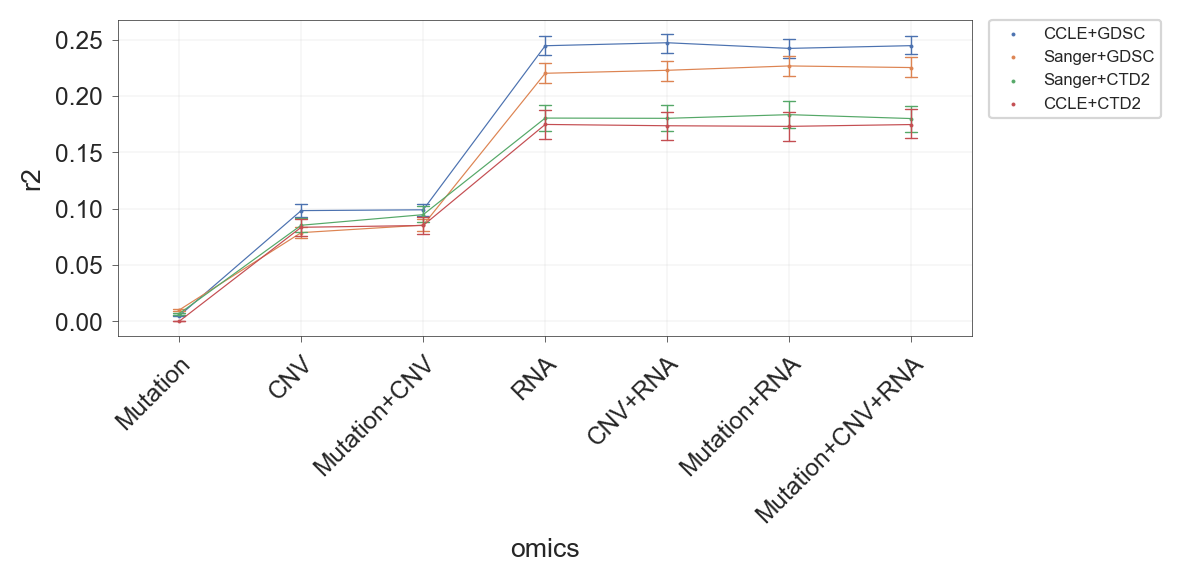

In [113]:
plt.figure(figsize=(6,3))
g = sns.pointplot(x="omics",
                  y="r2",
                  hue="data",
                  capsize=.1,
                  data=combined_group_df,
                  markersize=0,
                  scale=0.2,
                  aspect=3,
                  errwidth=0.5)
for axis in ['top', 'bottom', 'left', 'right']:
    g.spines[axis].set_linewidth(0.25)
g.tick_params(direction='out', length=2, width=0.25)
g.grid(True, ls="-", lw=0.1, alpha=1.0, zorder=0)
plt.setp(g.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., prop={'size': 6})
plt.tight_layout()
plt.savefig("../../plots/drug_omics_comparison_r2.pdf", dpi=500)

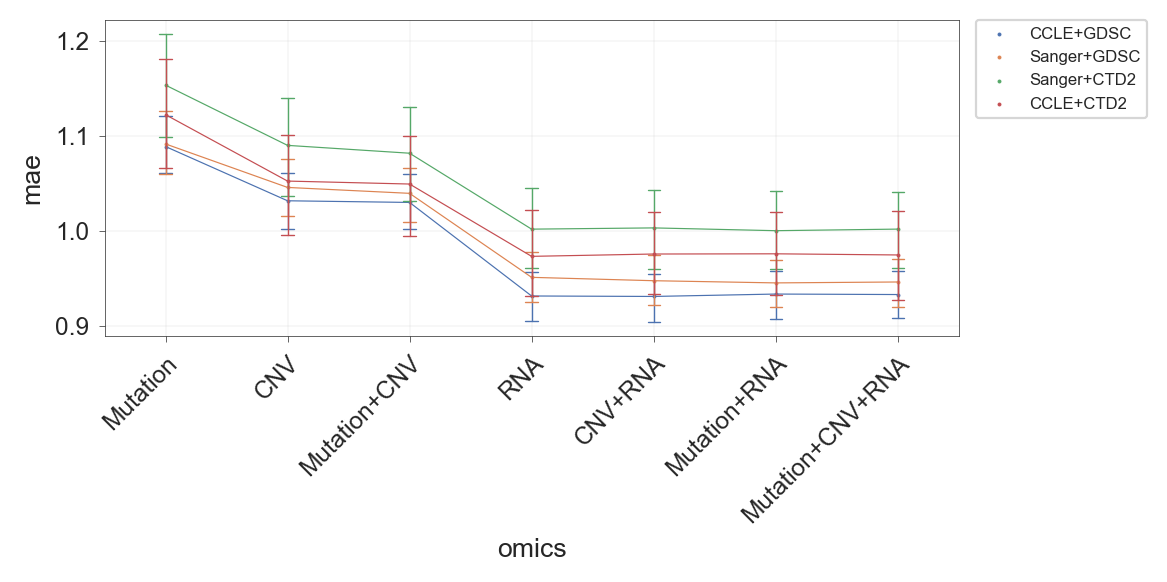

In [114]:
plt.figure(figsize=(6,3))
g = sns.pointplot(x="omics",
                  y="mae",
                  hue="data",
                  capsize=.1,
                  data=combined_group_df,
                  markersize=0,
                  scale=0.2,
                  aspect=3,
                  errwidth=0.5)
for axis in ['top', 'bottom', 'left', 'right']:
    g.spines[axis].set_linewidth(0.25)
g.tick_params(direction='out', length=2, width=0.25)
g.grid(True, ls="-", lw=0.1, alpha=1.0, zorder=0)
plt.setp(g.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., prop={'size': 6})
plt.tight_layout()
plt.savefig("../../plots/drug_omics_comparison_mae.pdf", dpi=500)

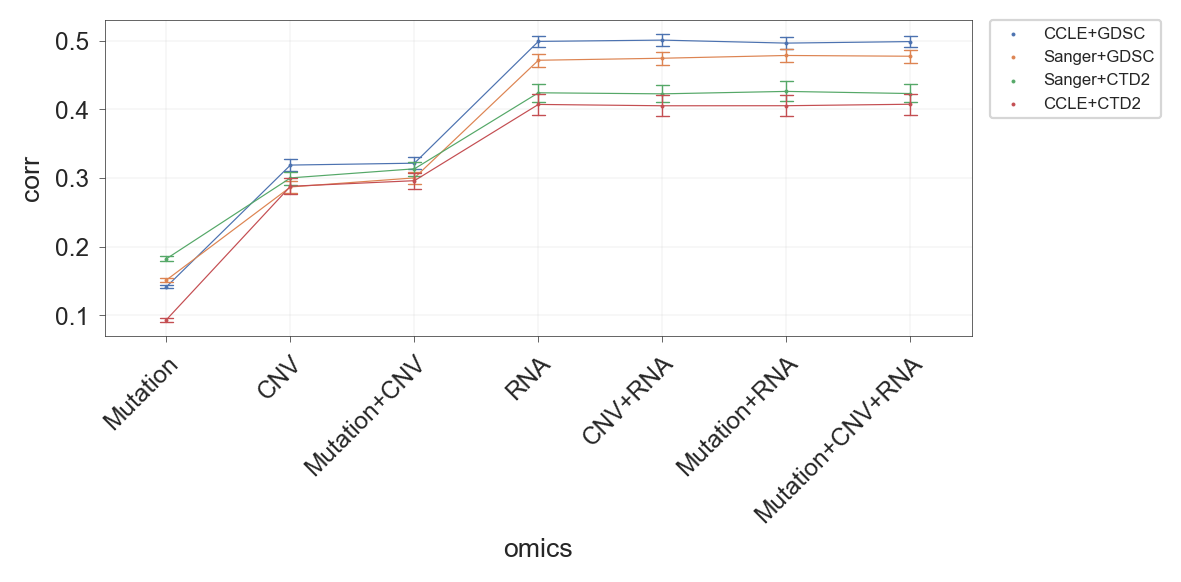

In [115]:
plt.figure(figsize=(6,3))
g = sns.pointplot(x="omics",
                  y="corr",
                  hue="data",
                  capsize=.1,
                  data=combined_group_df,
                  markersize=0,
                  scale=0.2,
                  aspect=3,
                  errwidth=0.5)
for axis in ['top', 'bottom', 'left', 'right']:
    g.spines[axis].set_linewidth(0.25)
g.tick_params(direction='out', length=2, width=0.25)
g.grid(True, ls="-", lw=0.1, alpha=1.0, zorder=0)
plt.setp(g.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., prop={'size': 6})
plt.tight_layout()
plt.savefig("../../plots/drug_omics_comparison_corr.pdf", dpi=500)

# top drugs each omics

In [209]:
combined_df = pd.read_csv("../../results/drug_omics_comparison_dl.csv")

In [156]:
combined_df = combined_df[~combined_df['drug_id'].str.contains('\+')]

In [157]:
omics = combined_df['omics'].unique()

## GDSC

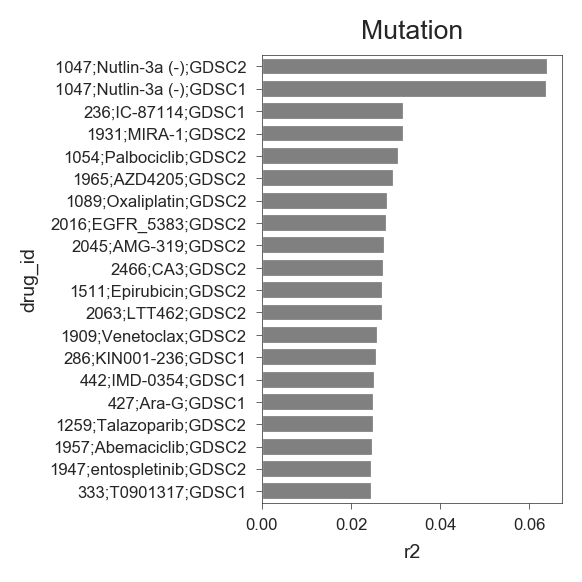

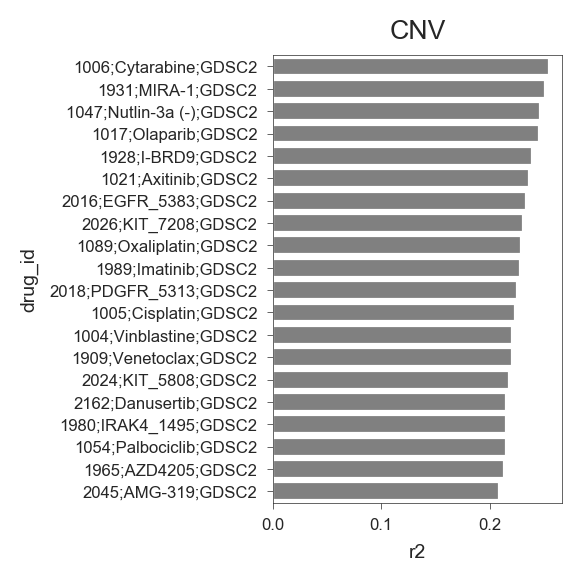

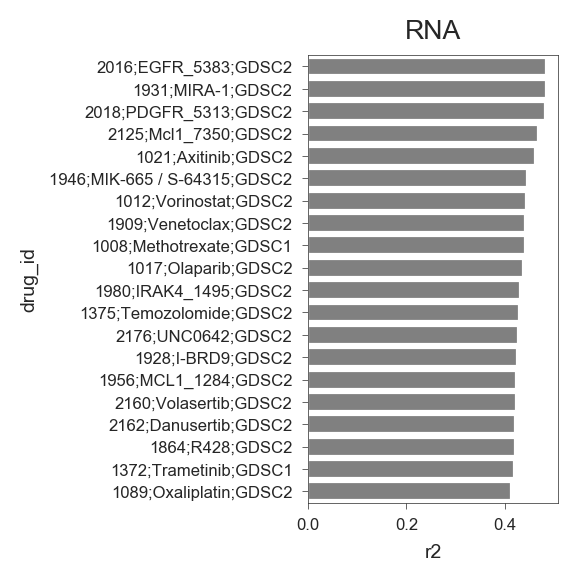

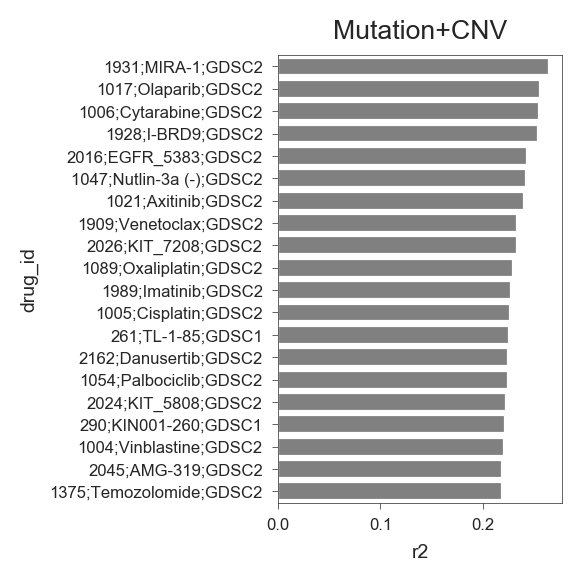

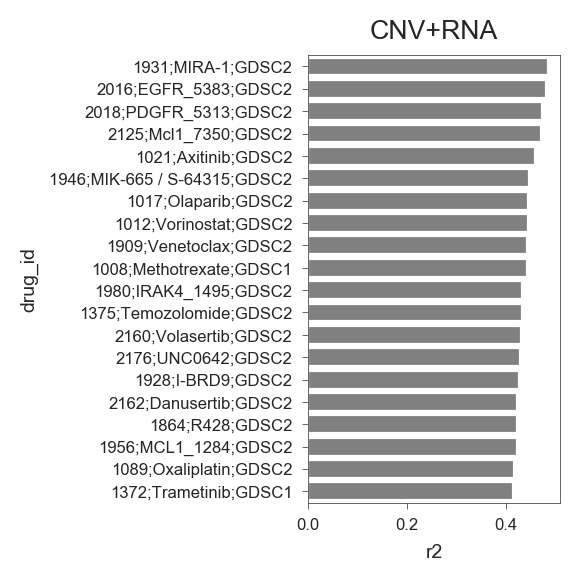

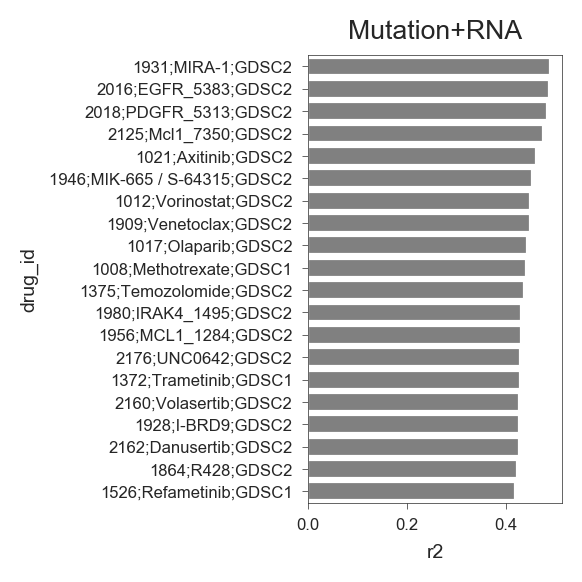

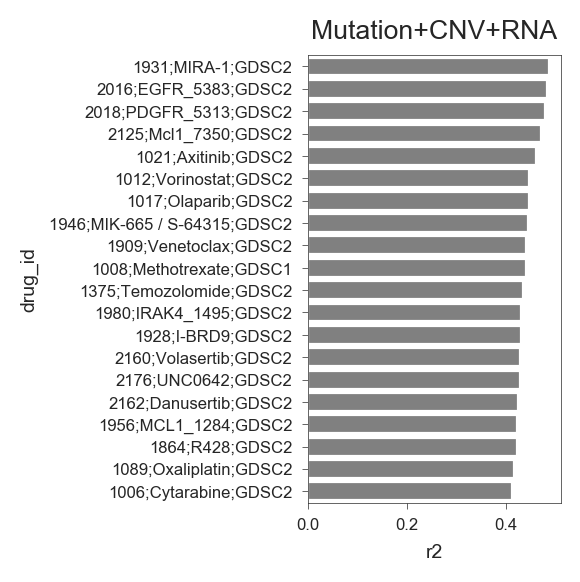

In [160]:
for omic in omics:
    gdsc_omic_df = combined_df.query(
        f'omics == "{omic}" and (data == "Sanger+GDSC" or data == "CCLE+GDSC")'
    )

    gdsc_omic_df = gdsc_omic_df.groupby('drug_id').mean()

    plot_df = gdsc_omic_df.sort_values(
        by='r2', ascending=False).head(20)[['r2']].reset_index()

    plt.figure(figsize=(3, 3))
    g = sns.barplot(y='drug_id', x='r2', data=plot_df, color='grey')
    g.set_title(omic)
    plt.tight_layout()
    plt.savefig(f"../../supp_plots/top_drugs/{omic}_gdsc.pdf", dpi=500)

In [194]:
combined_df_gdsc = combined_df.query(
        f'(data == "Sanger+GDSC" or data == "CCLE+GDSC")'
    )

combined_df_gdsc = combined_df_gdsc.groupby(['drug_id', 'omics']).mean().reset_index()

merged_gdsc_df = pd.merge(
    combined_df_gdsc.query('omics == "RNA"')[['drug_id', 'r2']],
    combined_df_gdsc.query('omics == "Mutation+CNV+RNA"')[['drug_id', 'r2']],
    on='drug_id',
    suffixes=['_rna', '_multiomics'])

merged_gdsc_df['delta'] = merged_gdsc_df['r2_multiomics'] - merged_gdsc_df['r2_rna']

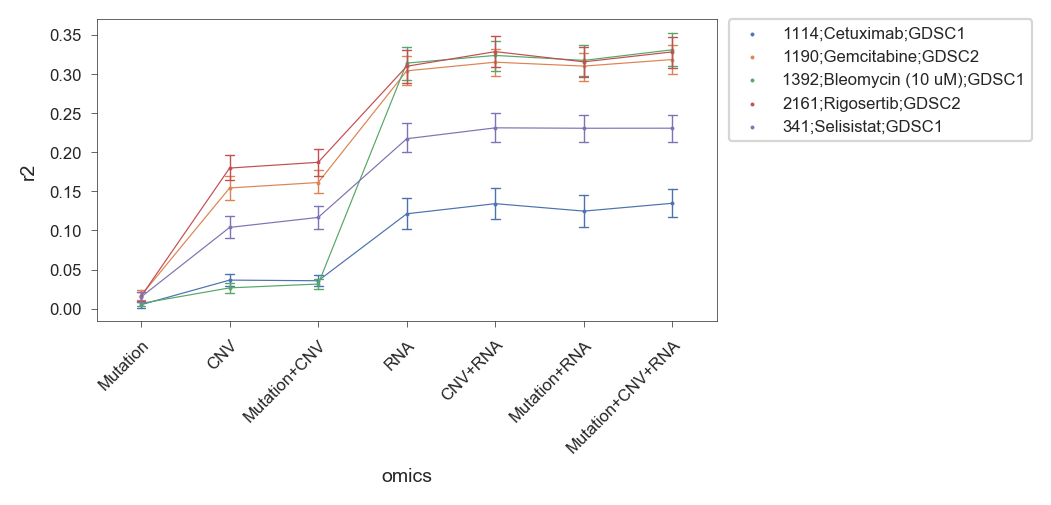

In [218]:
plt.figure(figsize=(4,2))
g = sns.pointplot(x="omics",
                  y="r2",
                  hue="drug_id",
                  capsize=.1,
                  data=combined_df[combined_df['drug_id'].isin(
                      merged_gdsc_df.sort_values(
                          by='delta',
                          ascending=False).head(5)['drug_id'].values)],
                  markersize=0,
                  scale=0.2,
                  aspect=3,
                  errwidth=0.5)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., prop={'size': 6})
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig("../../supp_plots/supp6_top_drug_gdsc.pdf")

## CTD2

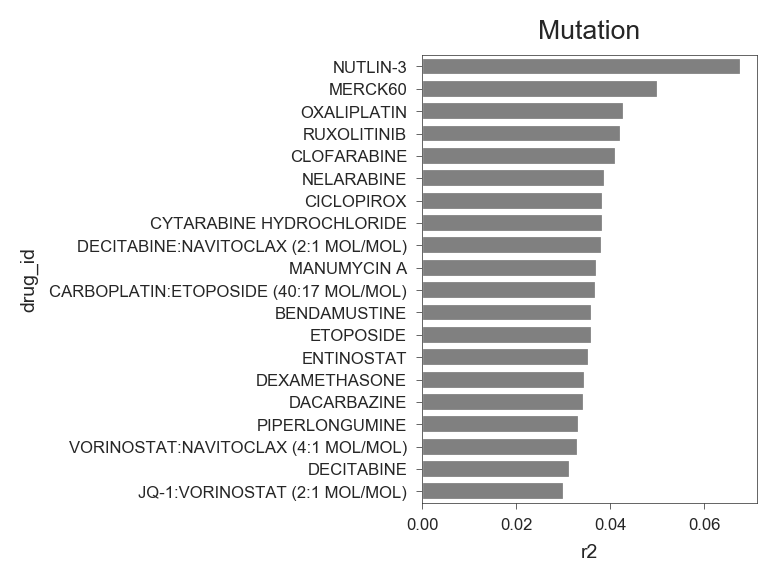

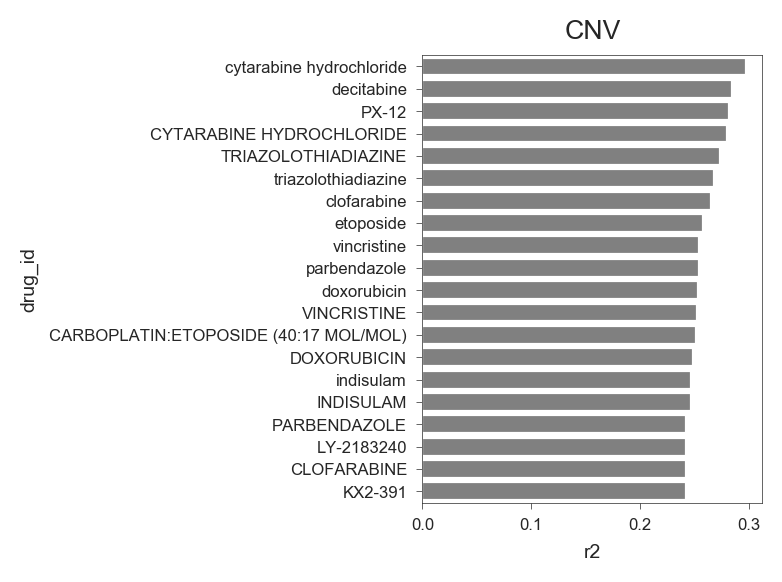

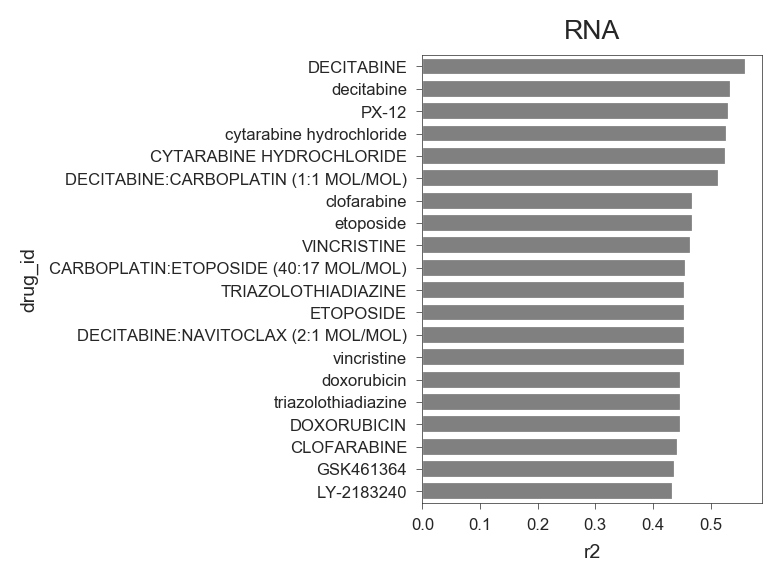

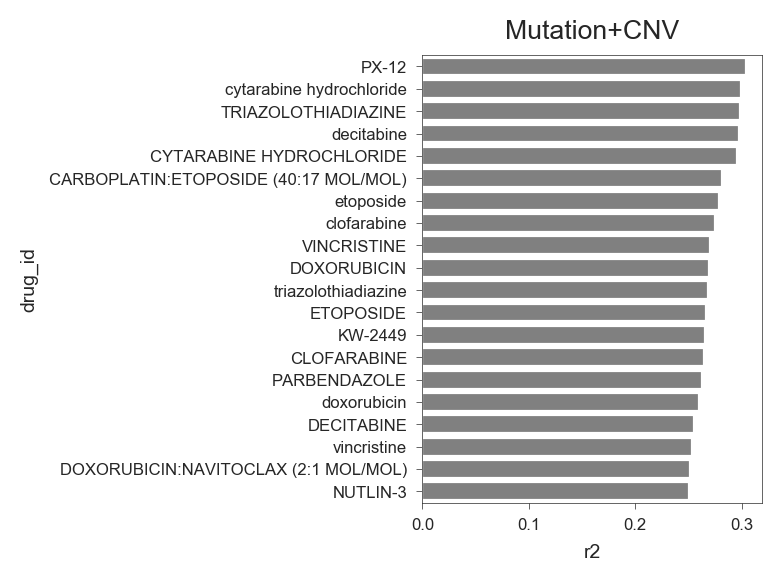

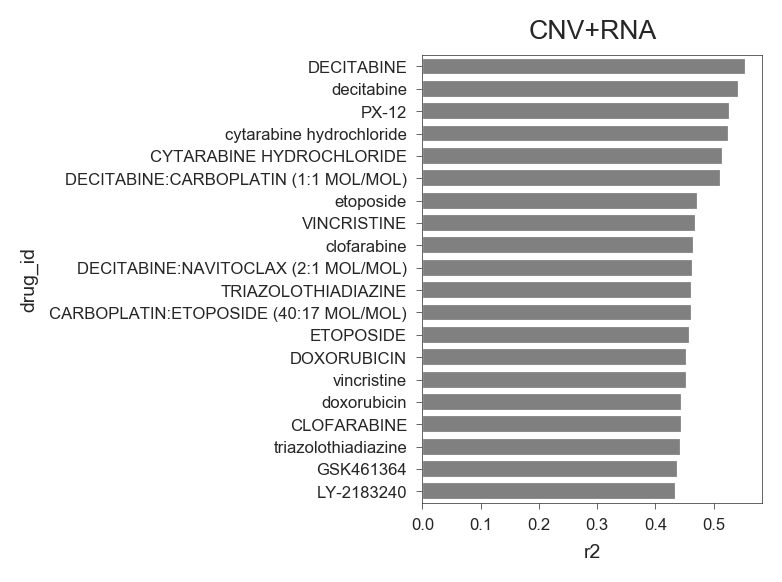

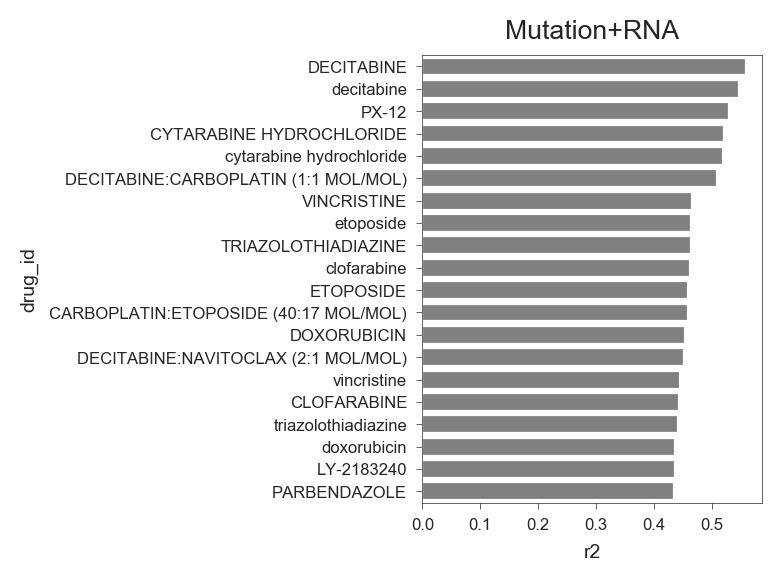

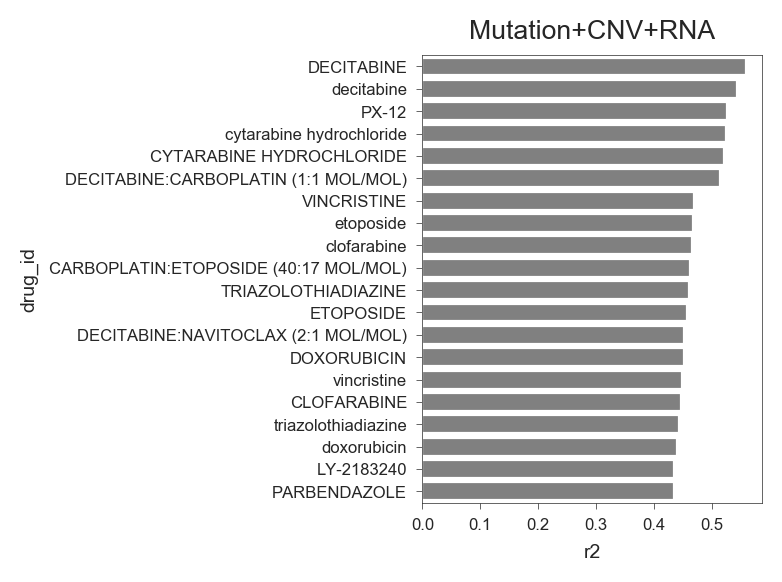

In [162]:
for omic in omics:
    ctd_omic_df = combined_df.query(
        f'omics == "{omic}" and (data == "Sanger+CTD2" or data == "CCLE+CTD2")'
    )

    ctd_omic_df = ctd_omic_df.groupby('drug_id').mean()

    plot_df = ctd_omic_df.sort_values(
        by='r2', ascending=False).head(20)[['r2']].reset_index()

    plt.figure(figsize=(4, 3))
    g = sns.barplot(y='drug_id', x='r2', data=plot_df, color='grey')
    g.set_title(omic)
    plt.tight_layout()
#     plt.show()
    plt.savefig(f"../../supp_plots/top_drugs/{omic}_ctd2.pdf", dpi=500)

In [202]:
combined_df_ctd2 = combined_df.query(
        f'(data == "Sanger+CTD2" or data == "CCLE+CTD2")'
    )

combined_df_ctd2 = combined_df_ctd2.groupby(['drug_id', 'omics']).mean().reset_index()

merged_ctd2_df = pd.merge(
    combined_df_ctd2.query('omics == "RNA"')[['drug_id', 'r2']],
    combined_df_ctd2.query('omics == "Mutation+CNV+RNA"')[['drug_id', 'r2']],
    on='drug_id',
    suffixes=['_rna', '_multiomics'])

merged_ctd2_df['delta'] = merged_ctd2_df['r2_multiomics'] - merged_ctd2_df['r2_rna']

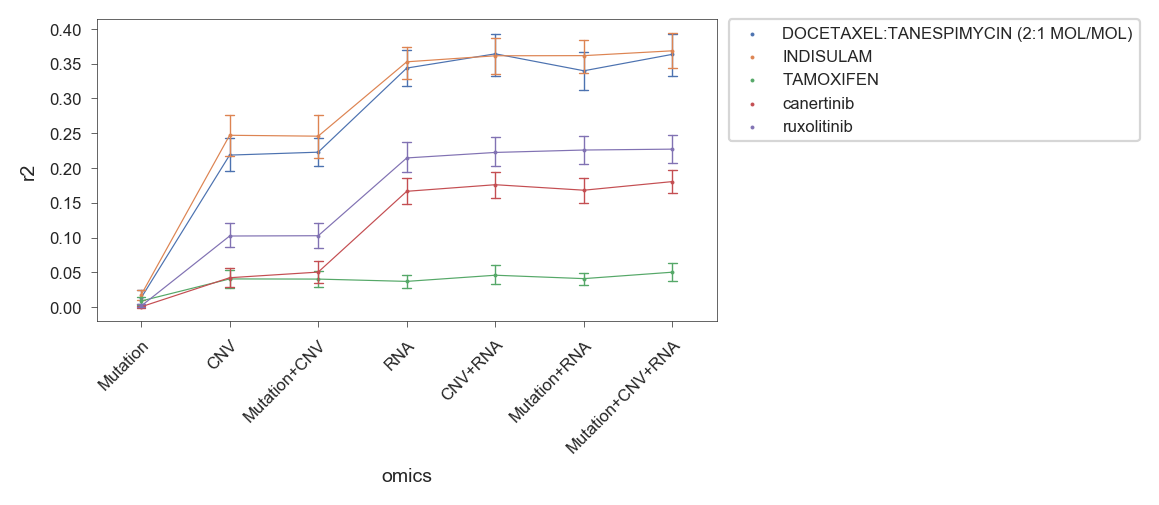

In [219]:
plt.figure(figsize=(4, 2))
g = sns.pointplot(x="omics",
                  y="r2",
                  hue="drug_id",
                  capsize=.1,
                  data=combined_df[combined_df['drug_id'].isin(
                      merged_ctd2_df.sort_values(
                          by='delta',
                          ascending=False).head(5)['drug_id'].values)],
                  markersize=0,
                  scale=0.2,
                  aspect=3,
                  errwidth=0.5)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., prop={'size': 6})
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig("../../supp_plots/supp6_top_drug_ctd2.pdf")